<a href="https://colab.research.google.com/github/eduion/DeepRL/blob/main/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# 1. 下載並使用外部 Gridworld.py 和 GridBoard.py
# 請將下列 URL 換成 raw 檔案的連結
!wget -q https://raw.githubusercontent.com/YourRepo/YourPath/Gridworld.py
!wget -q https://raw.githubusercontent.com/YourRepo/YourPath/GridBoard.py

In [48]:
# 2. 檢查 Gridworld.py 中的可用類別名稱
import inspect
import Gridworld
print("Available classes in Gridworld.py:", [name for name, obj in inspect.getmembers(Gridworld, inspect.isclass)])

Available classes in Gridworld.py: ['BoardMask', 'BoardPiece', 'GridBoard', 'Gridworld']


Episode 0: Reward=0.7
Episode 1: Reward=0.4199999999999997
Episode 2: Reward=0.7899999999999999
Episode 3: Reward=0.86
Episode 4: Reward=0.7799999999999999
Episode 5: Reward=-0.5000000000000011
Episode 6: Reward=0.5799999999999998
Episode 7: Reward=0.74
Episode 8: Reward=0.75
Episode 9: Reward=0.8099999999999999
Episode 10: Reward=0.9
Episode 11: Reward=0.92
Episode 12: Reward=-0.7500000000000013
Episode 13: Reward=0.9299999999999999
Episode 14: Reward=0.85
Episode 15: Reward=-0.8200000000000014
Episode 16: Reward=0.83
Episode 17: Reward=0.87
Episode 18: Reward=0.9299999999999999
Episode 19: Reward=0.8099999999999999
Episode 20: Reward=-0.33000000000000096
Episode 21: Reward=0.83
Episode 22: Reward=0.9299999999999999
Episode 23: Reward=0.89
Episode 24: Reward=0.9299999999999999
Episode 25: Reward=0.9299999999999999
Episode 26: Reward=0.82
Episode 27: Reward=0.21999999999999953
Episode 28: Reward=0.9299999999999999
Episode 29: Reward=0.9299999999999999
Episode 30: Reward=0.9299999999999

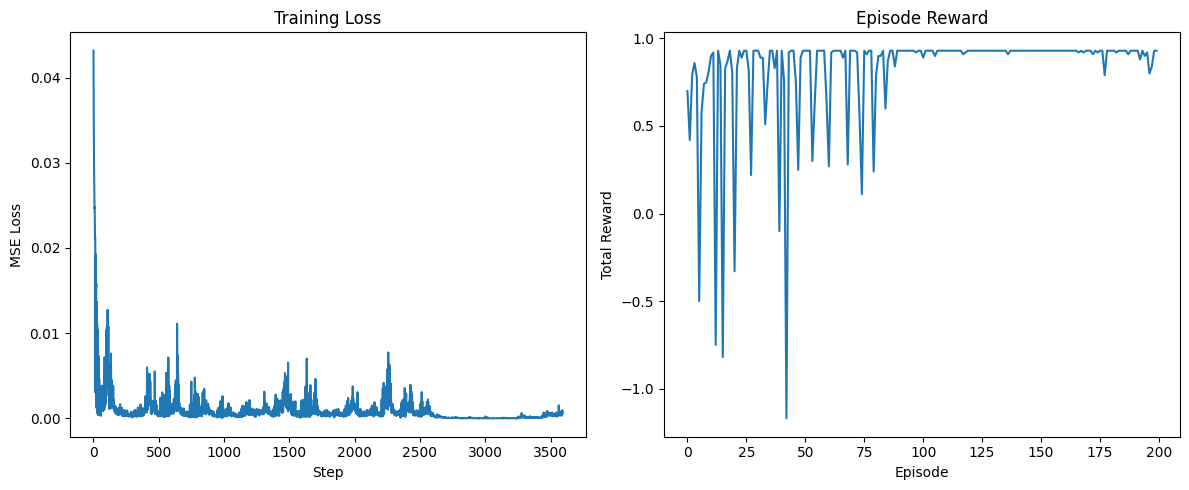

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# 1. 定義 Grid 環境（內建於此檔）
class GridEnv:
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.n_states = width * height
        self.n_actions = 4  # Up, Down, Left, Right
        self.start = 0
        self.goal = self.n_states - 1
        self.reset()

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x = self.state % self.width
        y = self.state // self.width
        if action == 0 and y > 0:       # Up
            y -= 1
        elif action == 1 and y < self.height - 1:  # Down
            y += 1
        elif action == 2 and x > 0:     # Left
            x -= 1
        elif action == 3 and x < self.width - 1:   # Right
            x += 1
        next_state = y * self.width + x
        done = (next_state == self.goal)
        # 設定步驟懲罰：非目標給予小懲罰，目標給予正回饋
        if done:
            reward = 1.0
        else:
            reward = -0.01  # 每走一步都有輕微懲罰，鼓勵更快到達
        self.state = next_state
        return next_state, reward, done, {}

# 2. One-hot 編碼
def one_hot(state, n_states):
    v = np.zeros(n_states, dtype=np.float32)
    v[state] = 1.0
    return v

# 3. 定義 DQN 網路
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# 4. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))
    def sample(self, bs):
        return random.sample(self.buffer, bs)
    def __len__(self):
        return len(self.buffer)

# 5. ε-greedy
def select_action(model, state_vec, eps, device):
    if random.random() < eps:
        return random.randrange(model.net[-1].out_features)
    st = torch.tensor(state_vec, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        qv = model(st)
    return int(qv.argmax(dim=1).item())

# 6. 訓練函式：DQN + Replay Buffer (Grid)
def train_dqn_grid(
    width=5, height=5,
    episodes=200,
    gamma=0.99,
    lr=1e-3,
    buffer_capacity=5000,
    batch_size=32,
    eps_start=1.0,
    eps_end=0.02,
    eps_decay=100
):
    env = GridEnv(width, height)
    n_states = env.n_states
    n_actions = env.n_actions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = DQN(n_states, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)

    all_rewards = []
    all_losses = []
    steps = 0

    for ep in range(episodes):
        state = env.reset()
        total_r = 0.0
        done = False
        while not done:
            eps = eps_end + (eps_start - eps_end) * np.exp(-1.0 * steps / eps_decay)
            s_vec = one_hot(state, n_states)
            a = select_action(model, s_vec, eps, device)

            ns, r, done, _ = env.step(a)
            ns_vec = one_hot(ns, n_states)
            total_r += r

            buffer.push(s_vec, a, r, ns_vec, done)

            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                ss, aa, rr, nss, dd = zip(*batch)
                s_v = torch.tensor(ss, dtype=torch.float32).to(device)
                a_v = torch.tensor(aa, dtype=torch.long).unsqueeze(1).to(device)
                r_v = torch.tensor(rr, dtype=torch.float32).to(device)
                ns_v = torch.tensor(nss, dtype=torch.float32).to(device)
                d_v = torch.tensor(dd, dtype=torch.bool).to(device)

                q_pred = model(s_v).gather(1, a_v).squeeze(1)
                with torch.no_grad():
                    q_next = model(ns_v).max(1)[0]
                    q_next[d_v] = 0.0
                    q_tgt = r_v + gamma * q_next

                loss = loss_fn(q_pred, q_tgt)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                all_losses.append(loss.item())

            state = ns
            steps += 1
        all_rewards.append(total_r)
        print(f"Episode {ep}: Reward={total_r}")

    return all_rewards, all_losses

# 7. 執行並繪圖
if __name__ == '__main__':
    rwds, lss = train_dqn_grid(width=5, height=5)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(lss)
    plt.title('Training Loss')
    plt.xlabel('Step')
    plt.ylabel('MSE Loss')

    plt.subplot(1,2,2)
    plt.plot(rwds)
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.tight_layout()
    plt.show()
